In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [3]:
from tensorflow.keras.models import Model

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import cv2

In [7]:
import os

In [8]:
from glob import glob

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
import scipy.io

In [11]:
tf.__version__

'2.0.0'

In [12]:
import build_model_1

In [48]:
data_size_y = 288
# data_size_y = 128
# data_size_y = 128

In [49]:
data_size_x = 512
# data_size_x = 256
# data_size_x = 128

In [50]:
BATCH_SIZE = 8

In [51]:
from sys import getsizeof

In [165]:
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred, max_val=64, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2))

In [202]:
# input_layer = Input((data_size_y, data_size_x, 3))
# model = build_model_1.build_model2(input_layer, 16)

model = keras.models.load_model('depth_3_large_5.h5', compile=False)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

model2 = keras.models.load_model('depth_3_large_4.h5', compile=False)
model2.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

model3 = keras.models.load_model('depth_3_large_3.h5', compile=False)
model3.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# model = build_model_1.DepthEstimationModel()

# model = model_from_json(open(modelFile).read())

In [203]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 288, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 288, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 288, 512, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 288, 512, 64) 256         conv2d_25[0][0]                  
____________________________________________________________________________________________

In [55]:
model.compile(loss=custom_loss, optimizer="adam", metrics=["accuracy"])

In [56]:
data_path = r"LR"

In [57]:
x_files = glob(os.path.join(data_path, 'color', '*.png'))

In [58]:
import random
random.shuffle(x_files)

In [59]:
validation_split = .2

In [60]:
split_break = int((1 - validation_split) * len(x_files))

In [61]:
train_ground = x_files[:split_break]
valid_ground = x_files[split_break:]

In [62]:
train_truth = [file.replace('color', 'depth_filled').replace('_c', '_depth_filled') for file in train_ground]
valid_truth = [file.replace('color', 'depth_filled').replace('_c', '_depth_filled') for file in valid_ground]

In [63]:
# dcombined = tf.data.Dataset.zip((datasetx, datasety)).batch(2)
# iterator = dcombined.make_one_shot_iterator()

In [100]:
def process_img8(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, dtype=tf.dtypes.uint8, channels=0)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(data_size_y, data_size_x))
    
#     img = tf.where(img > .5, 1, 0)
    
#     img = tf.image.resize(img, size=(28, 28))
    return img

def process_img16(file_path):
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, dtype=tf.dtypes.uint8, channels=0)
    img = tf.image.convert_image_dtype(img, tf.float32) * 11.5
    img = tf.image.resize(img, size=(data_size_y, data_size_x))
    
    return img

In [101]:
train_ds = tf.data.Dataset.from_tensor_slices((train_ground, train_truth))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_ground, valid_truth))

In [102]:
train_ds = train_ds.map(lambda x, y: (process_img8(x), process_img16(y))).batch(BATCH_SIZE)
valid_ds = valid_ds.map(lambda x, y: (process_img8(x), process_img16(y))).batch(BATCH_SIZE)

Learning rate per epoch:


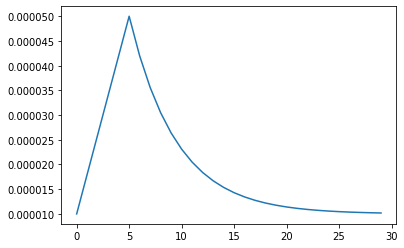

In [150]:
EPOCHS = 30

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [151]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[lr_callback]) 


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
161/161 [==============================] - 151s 939ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/30
161/161 [==============================] - 151s 939ms/step - loss: 0.0236 - accuracy: 0.0000e+00 - val_loss: 0.0538 - val_accuracy: 0.0000e+00

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/30
161/161 [==============================] - 151s 940ms/step - loss: 0.0229 - accuracy: 0.0000e+00 - val_loss: 0.0524 - val_accuracy: 0.0000e+00

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/30
161/161 [==============================] - 152s 944ms/step - loss: 0.0241 - accuracy: 0.0000e+00 - val_loss: 0.0523 - val_accuracy: 0.0000e+00

Epoch 00005: LearningRateScheduler reducing learning

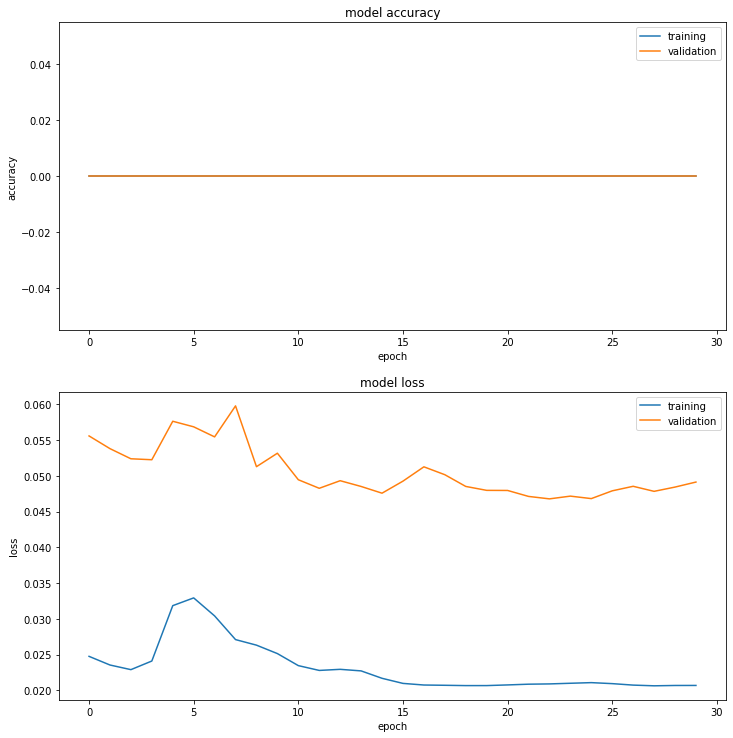

In [152]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [161]:
# model.save('depth_3_large_5.h5')

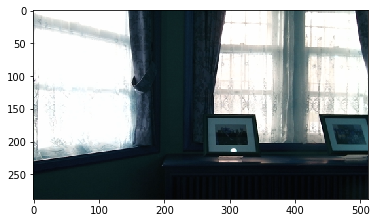

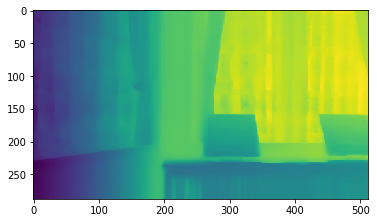

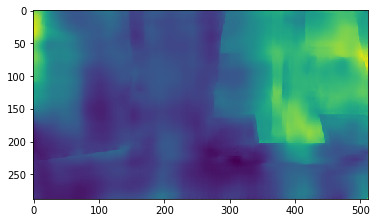

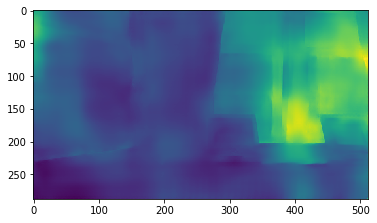

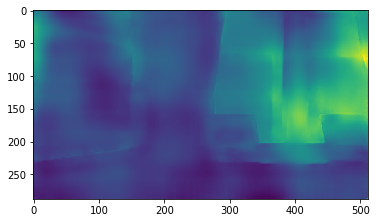

In [213]:
# image = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)

image_value = 63

image = cv2.resize(cv2.imread(valid_ground[image_value]), (data_size_x, data_size_y))
# image = x_test[29]

image = image / 255

truth = cv2.resize(cv2.imread(valid_truth[image_value], cv2.IMREAD_ANYDEPTH), (data_size_x, data_size_y))
# truth = y_test[29]

truth = truth / 255

guess = model.predict(image.reshape(-1,data_size_y, data_size_x,3))
guess2 = model2.predict(image.reshape(-1,data_size_y, data_size_x,3))
guess3 = model3.predict(image.reshape(-1,data_size_y, data_size_x,3))

plt.imshow(image)
plt.show()
plt.imshow(truth)
plt.show()
plt.imshow(guess.reshape(data_size_y, data_size_x))
plt.show()
plt.imshow(guess2.reshape(data_size_y, data_size_x))
plt.show()
plt.imshow(guess3.reshape(data_size_y, data_size_x))
plt.show()